In [1]:
include("../../../autocorrelation-shell/src/AutocorrelationShell.jl")
using Main.AutocorrelationShell

┌ Info: Precompiling DSP [717857b8-e6f2-59f4-9121-6e50c889abd2]
└ @ Base loading.jl:1273
┌ Info: Precompiling Wavelets [29a6e085-ba6d-5f35-a997-948ac2efa89a]
└ @ Base loading.jl:1273


In [2]:
using DataFrames,CSV,Plots,Wavelets,Clustering,Distances,LinearAlgebra,Loess,StatsBase,Statistics

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


### Data Source
Link to the [dataset](https://www.imf.org/en/Research/commodity-prices) from the International Monetary Fund. 

Note that commodity indices are based in 2016 (average of 2016 = 100).

### Read the Data

In [4]:
#path = "./data/commodity_monthly.csv" # Monthly data
path = "../data/commodity_quarterly.csv" # Quarterly data

data = CSV.read(path)
df = data[:,1:ncol(data)-1] # Remove last col of missing values
#df = dropmissing(data)

# Split Indices/Market Prices by group and by commodity
index_bool = occursin.("index",lowercase.(df[:,Symbol("Commodity Name")]))
df_group = df[index_bool,:]
df_comm = df[.!index_bool,:]

279×128 DataFrame. Omitted printing of 125 columns
│ Row │ Country Name │ Country Code │ Commodity Name                   │
│     │ String       │ Int64        │ String                           │
├─────┼──────────────┼──────────────┼──────────────────────────────────┤
│ 1   │ World        │ 1            │ Silver                           │
│ 2   │ World        │ 1            │ Silver                           │
│ 3   │ World        │ 1            │ Vegetables, Tomato               │
│ 4   │ World        │ 1            │ Vegetables, Tomato               │
│ 5   │ World        │ 1            │ Urea                             │
│ 6   │ World        │ 1            │ Urea                             │
│ 7   │ World        │ 1            │ Diammonium phosphate             │
│ 8   │ World        │ 1            │ Molybdenum                       │
│ 9   │ World        │ 1            │ Dairy Products, Milk             │
│ 10  │ World        │ 1            │ Oats                             │
⋮
│ 269 │ World        │ 1            │ Hard Sawnwood, Dark Red Meranti  │
│ 270 │ World        │ 1            │ LNG, Asia                        │
│ 271 │ World        │ 1            │ Wool, Coarse                     │
│ 272 │ World        │ 1            │ Wool, Fine                       │
│ 273 │ World        │ 1            │ Wool, Fine                       │
│ 274 │ World        │ 1            │ Zinc                             │
│ 275 │ World        │ 1            │ Zinc                             │
│ 276 │ World        │ 1            │ APSP crude oil($/bbl)            │
│ 277 │ World        │ 1            │ APSP crude oil($/bbl)            │
│ 278 │ World        │ 1            │ APSP crude oil($/bbl)            │
│ 279 │ World        │ 1            │ APSP crude oil($/bbl)            │

### Visualize the Data
Note: Uncomment `plotly()` to see commodity labels in plot below.

In [5]:
function plot_series(df,units)
    #plotly()
    
    df = df[df[:,Symbol("Unit Name")] .== units,:]
    x = transpose(convert(Matrix,df[:,8:ncol(df)]))

    legendlabel=reshape(df[:,Symbol("Commodity Name")],(1,size(x)[2]))
    timelabel=map(string,names(df[:,8:ncol(df)]))

    plot(x,xrotation=45,
         labels=legendlabel,size=(1000,500),
         xticks=(1:4:size(x)[1],timelabel[1:4:size(x)[1]]),
         legend = :none)
    ylabel!(units)
end

plot_series (generic function with 1 method)

#### US Dollars

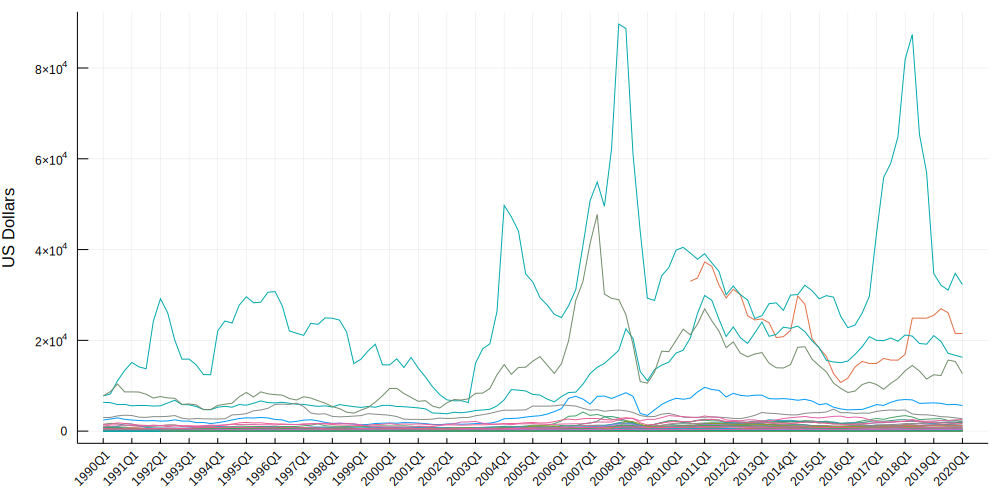

In [6]:
plot_series(df_comm,"US Dollars")

#### Index

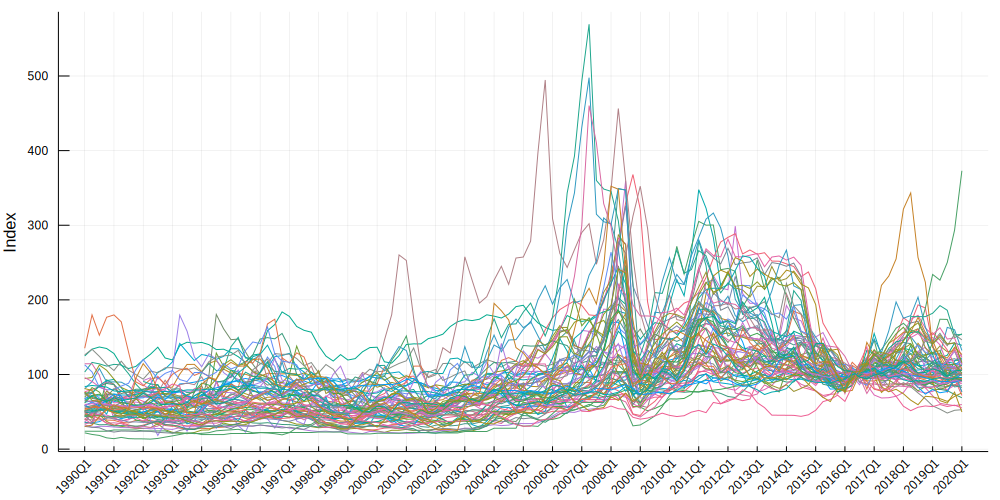

In [7]:
plot_series(df_comm,"Index")

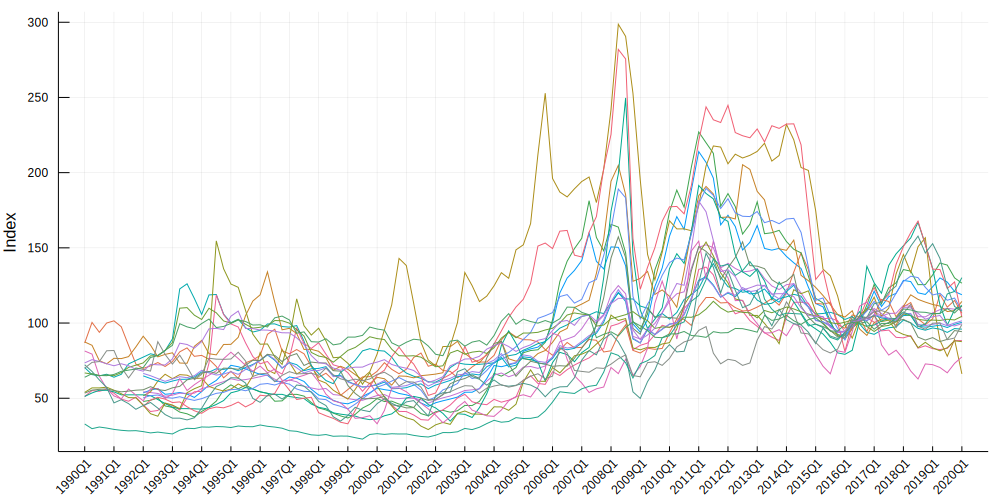

In [8]:
plot_series(df_group,"Index")

#### Percent Change over Previous Period

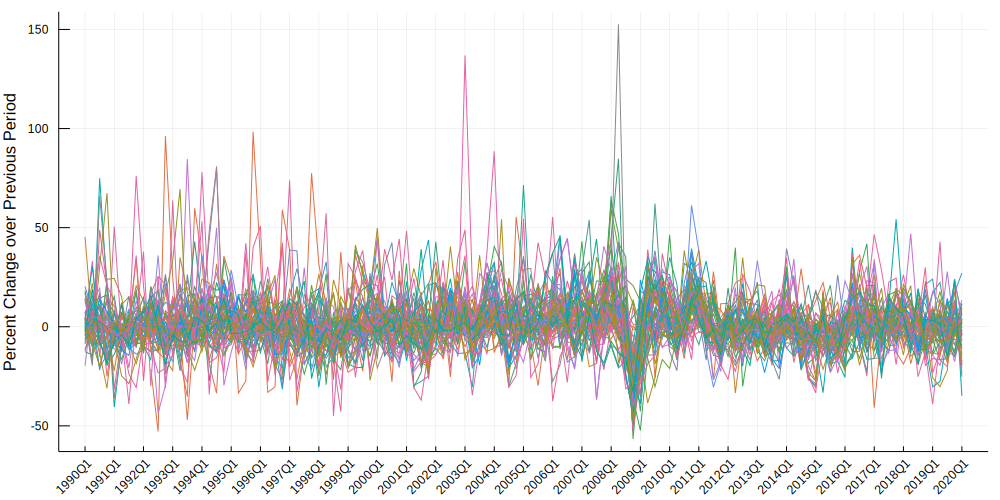

In [9]:
plot_series(df_comm,"Percent Change over Previous Period")

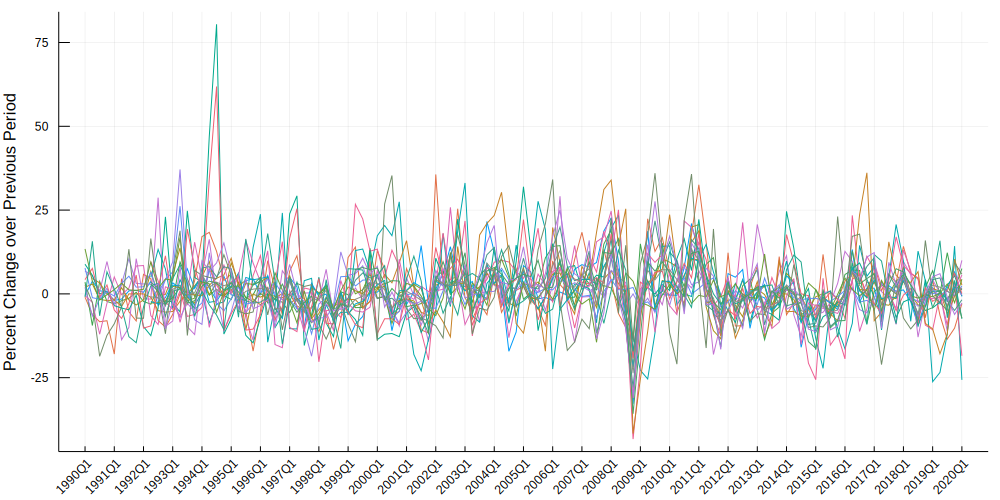

In [10]:
plot_series(df_group,"Percent Change over Previous Period")

#### Percent Change over Corresponding Period Previous Year

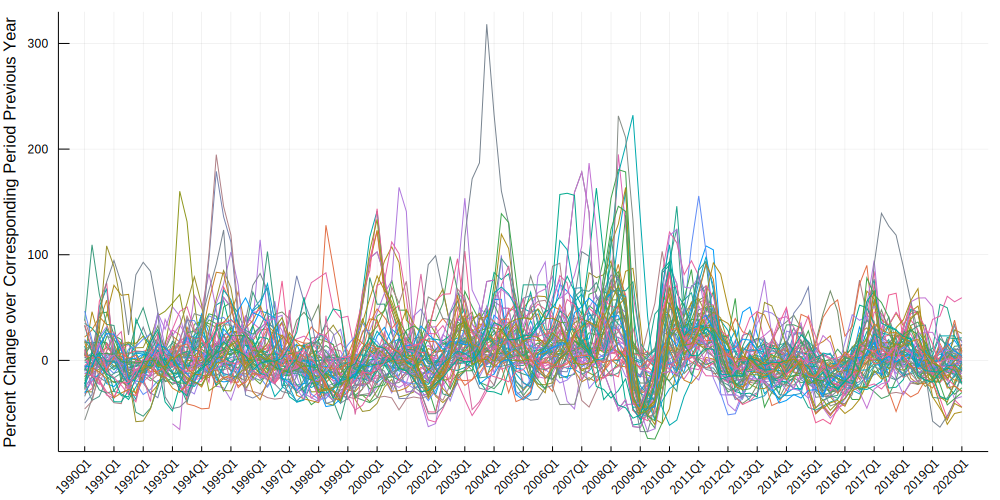

In [11]:
plot_series(df_comm,"Percent Change over Corresponding Period Previous Year")

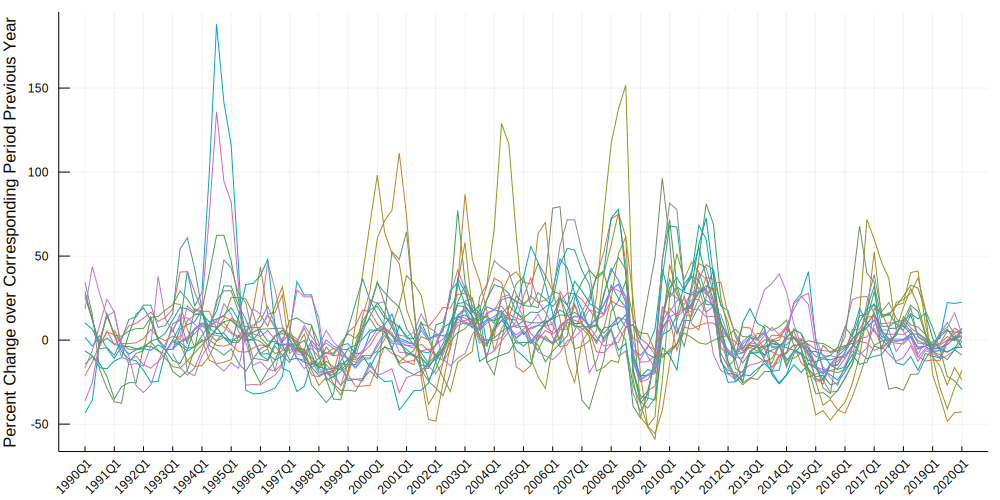

In [12]:
plot_series(df_group,"Percent Change over Corresponding Period Previous Year")

### AC2D Analysis

In [13]:
# List all indices
unique(df_group[:,Symbol("Commodity Name")])

22-element Array{String,1}:
 "Precious Metals Price Index"
 "Vegetable oil index "       
 "Wool index "                
 "Seafood index "             
 "Energy index "              
 "Agr. Raw Material Index "   
 "Non-Fuel index "            
 "Natural gas index "         
 "Cereal  index"              
 "Coal index "                
 "Coffee index "              
 "Food and beverage index"    
 "Food index "                
 "Hardwood index "            
 "Industrial Materials index "
 "Meat Index "                
 "Metal index "               
 "Timber index "              
 "Beverages index "           
 "Softwood index "            
 "Sugar index "               
 "All index "                 

In [14]:
# Select indices
# ["Precious Metals Price Index","Vegetable oil index ","Wool index ","Seafood index ","Energy index ",
#  "Agr. Raw Material Index ","Non-Fuel index ","Natural gas index ","Cereal  index","Coal index ",
#  "Coffee index ","Food and beverage index","Food index ","Hardwood index ","Industrial Materials index ",
#  "Meat Index ","Metal index ","Timber index ","Beverages index ","Softwood index ","Sugar index ","All index "]

comm_names = ["Precious Metals Price Index","Vegetable oil index ","Wool index ","Seafood index ","Energy index ",
 "Agr. Raw Material Index ","Non-Fuel index ","Natural gas index ","Cereal  index","Coal index ",
 "Food index ","Hardwood index ","Industrial Materials index ","Meat Index ","Metal index ",
 "Beverages index ","Softwood index ","Sugar index "]

18-element Array{String,1}:
 "Precious Metals Price Index"
 "Vegetable oil index "       
 "Wool index "                
 "Seafood index "             
 "Energy index "              
 "Agr. Raw Material Index "   
 "Non-Fuel index "            
 "Natural gas index "         
 "Cereal  index"              
 "Coal index "                
 "Food index "                
 "Hardwood index "            
 "Industrial Materials index "
 "Meat Index "                
 "Metal index "               
 "Beverages index "           
 "Softwood index "            
 "Sugar index "               

In [15]:
# Specify dataset 
function get_data(df,units)
    df = df[df[:,Symbol("Unit Name")] .== units,:]
    all_names = df[:,Symbol("Commodity Name")]
    all_times = names(df)[8:ncol(df)]
    x = convert(Matrix,df[:,8:ncol(df)])
    return x,all_names,all_times
end

# Remove some commodity indices
bool = [in(i,comm_names) for i in df_group[:,Symbol("Commodity Name")]]
df_group_sub = df_group[bool,:]

# Get data
dat,all_names,all_times = get_data(df_group_sub,"Index")
print("----- Original Data -----\n")
print(string("missing count (columns): ", [sum(ismissing.(dat[i,:])) for i in 1:size(dat)[1]]'))
print(string("\nsize: ", size(dat),"\n"))

# Subset data to get rid of missing values
row_dat,col_dat = size(dat)
x = identity.(dat[:,col_dat-112:col_dat])

#legendlabel=reshape(all_names,(1,size(x)[2]))
timelabel=map(string,all_times)[col_dat-112:col_dat]

print("\n----- Subset Data -----\n")
print(string("missing count (columns): ", [sum(ismissing.(x[i,:])) for i in 1:size(x)[1]]'))
print(string("\nsize: ", size(x)))

----- Original Data -----
missing count (columns): [8 0 8 8 8 0 0 0 0 8 8 0 0 0 0 0 0 0]
size: (18, 121)

----- Subset Data -----
missing count (columns): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
size: (18, 113)

In [16]:
# mi = minimum(x)
# ma = maximum(x)
# heatmap(x, clim=(mi,ma))

In [17]:
minimum([0,1,2,3])
minimum(vcat([3,4],[5,6]))
get_clim([0,2,3])
get_clim(log.(x))

UndefVarError: UndefVarError: get_clim not defined

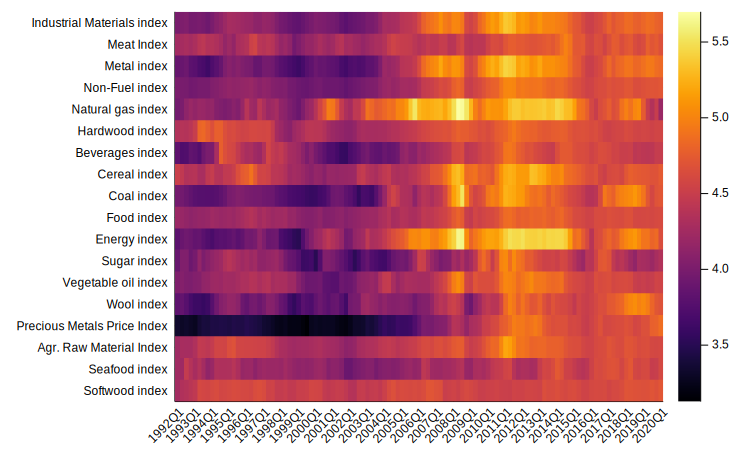

In [18]:
H = wavelet(WT.db2)
L_row = 2
L_col = 2
Q = qfilter(H)
P = pfilter(H)

ac = ac2d(x,L_row,L_col,P,Q)

function get_clim(x)
    logx = log.(abs.(x))
    return (minimum(logx),maximum(logx))
end

function plot_heatmap(x,climit)
   heatmap(log.(abs.(x)),
            clim=climit,
            yflip=true,
            colorbar_entry=true,
            #aspect_ratio=:equal,
            showaxis=false,
            size=(600,400))
end

function plot_heatmap_label(x,yticks_lab,climit)
   heatmap(log.(abs.(x)),
            clim=climit,
            yflip=true,
            colorbar_entry=true,
            #aspect_ratio=:equal,
            #showaxis=false,
            size=(750,450),
            xrotation=45,
            xticks=(1:4:size(x)[2],timelabel[1:4:size(x)[2]]),
            yticks = (1:1:size(x)[1], yticks_lab))
end

# Heatmap of original data
climit = get_clim(x)
plot_heatmap_label(x,all_names,climit)

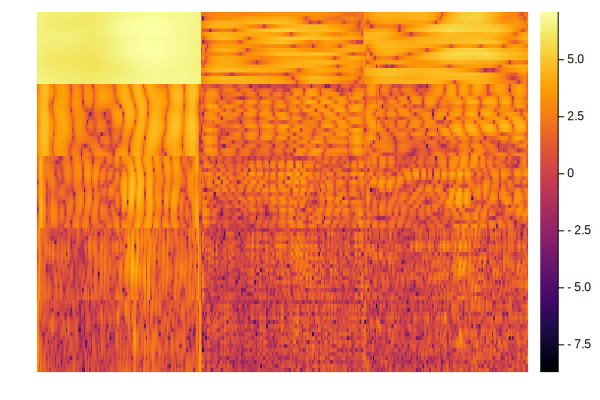

In [19]:
# Grid of all scales
row_dim,col_dim,row_scale,col_scale=size(ac)
tmp=[reduce(vcat, [ac[:,:,j,i] for j in 1:row_scale]) for i in 1:col_scale]
x_reshape=reduce(hcat, tmp)
climit = get_clim(x_reshape)
plot_heatmap(x_reshape,climit)

### Normalization

##### Unit Length

In [20]:
function normalize_unit(x,axis)
    if axis == 2 # normalize rows to unit length
        v = [1/norm(x[i, :]) for i in 1:size(x)[1]]
        #v = [norm(x[i, :]) != 0 ? 1/norm(x[i, :]) : 0 for i in 1:size(x)[1]]
        x_normalize_unit = v .* x
    elseif axis == 1 # normalize columns to unit length
        v = [1/norm(x[:, i]) for i in 1:size(x)[2]]
        #v = [norm(x[:,i]) != 0 ? 1/norm(x[:,i]) : 0 for i in 1:size(x)[2]]
        x_normalize_unit = transpose(v .* x')
    end
    return x_normalize_unit
end

x_normalize_unit_row = normalize_unit(x,2)
x_normalize_unit_col = normalize_unit(x,1)
x_normalize_unit = x_normalize_unit_row
sum([norm(x_normalize_unit[i, :]) for i in 1:size(x)[1]]) # check
#sum([norm(x_normalize_unit[:, i]) for i in 1:size(x)[2]]) # check

18.0

##### Loess

In [32]:
# Example for one vector
xs = collect(1:size(x)[2])
ys = x[5,:]
model = loess(xs, ys)

us = range(extrema(xs)...; step = 0.1)
vs = Loess.predict(model, us)

p1 = plot(xs,ys,legend=:none)
plot!(us,vs)

p2 = plot(xs,ys - vs[1:10:end],legend=:none)

plot(p1, p2,layout = (1, 2),size=(700,300))

<!DOCTYPE html>
 
 
 Plots.jl

In [136]:
function loess_fitted_1d(x,i,axis)
    """
    Input:
        x -- data matrix
        i -- index of row or column to normalize
        axis -- "2" to normalize rows, "1" to normalize columns
    Output:
        loess curve for the specified index
    """
    if axis == 2 # normalize rows to unit length
        xs = collect(1:size(x)[2])
        ys = x[i,:]
        model = loess(xs, ys)
    elseif axis == 1 # normalize columns to unit length
        xs = collect(1:size(x)[1])
        ys = x[:,i]
        model = loess(xs, ys)
    end
    
    us = range(extrema(xs)...; step = 0.1)
    vs = Loess.predict(model, us)[1:10:end]
    return vs
end

function loess_fitted(x,axis)
    """
    Input:
        x -- data matrix
        axis -- "2" to normalize rows, "1" to normalize columns
    Output:
        matrix of fitted loess curves
    """
    if axis == 2 # normalize rows to unit length
        x_loess = hcat([loess_fitted_1d(x,i,2) for i in 1:size(x)[1]]...)'
    elseif axis == 1 # normalize columns to unit length
        x_loess = hcat([loess_fitted_1d(x,i,1) for i in 1:size(x)[2]]...)
    end
    
    return x_loess
end

# function normalize_loess(x,fitted)
#     """
#     Input:
#         x -- data matrix
#         fitted -- matrix of fitted loess curves
#     Output:
#         data matrix normalized by subtracting loess curve from its respective vector
#     """
#     return x - fitted
# end

# Normalize using loess
loess_fit_row = loess_fitted(x,2)
loess_fit_col = loess_fitted(x,1)

x_normalize_loess_row = x - loess_fit_row
x_normalize_loess_col = x - loess_fit_col

t = loess_fitted(x_normalize_loess_row,1)
x_normalize_loess = x_normalize_loess_row - t

18×113 Array{Float64,2}:
  -4.22055     -4.27087    -4.45931    -2.71934    …    0.769395    2.90252
   1.53999      1.27298     1.42637     1.67487        -5.77659   -10.3481
   4.17156      4.31031     4.30764     0.496491        8.29083    10.4102
   7.69209      6.60041     4.23436     1.58205         0.496067    6.9877
  -0.330818     3.28527    10.1799     13.3415         -3.86366   -19.306
 -16.274      -12.0432    -12.4016    -11.0314     …   -1.22429     0.0717812
  -0.0665974   -3.90789    -3.28113    -3.06208         0.973657    1.11041
   6.83187      3.92061    -0.901478   -0.62291        12.67       19.2325
   1.79062      3.79394     4.61372     2.82112       -16.413     -15.4948
   3.19745      0.672836    0.148414    0.0531833      -4.9054     -1.84843
  -1.67482      0.342093    3.70418     6.24084    …   14.4612     -1.56812
  -7.8552      -3.90616    -2.8294     -6.45906         0.550144   10.0248
  -1.28103     -3.05308    -4.22306    -2.09055         4.99737     7

##### Remove linear trend

In [21]:
function linear_fitted_1d(x,i,axis)
    if axis == 2 # normalize rows to unit length
        xs = collect(1:size(x)[2])
        p1 = [xs[1], x[i,:][1]]
        pn = [xs[size(x)[2]], x[i,:][size(x)[2]]]
        m = (pn[2]-p1[2])/(pn[1]-p1[1])
        b = p1[2] - m*p1[1]
        line = m.*xs .+ b
    elseif axis == 1 # normalize columns to unit length
        xs = collect(1:size(x)[1])
        p1 = [xs[1], x[:,i][1]]
        pn = [xs[size(x)[1]], x[:,i][size(x)[1]]]
        m = (pn[2]-p1[2])/(pn[1]-p1[1])
        b = p1[2] - m*p1[1]
        line = m.*xs .+ b
    end
    return line
end

function linear_fitted(x,axis)
    """
    Input:
        x -- data matrix
        axis -- "2" to normalize rows, "1" to normalize columns
    Output:
        matrix of fitted lines
    """
    if axis == 2 # normalize rows to unit length
        x_linear = hcat([linear_fitted_1d(x,i,2) for i in 1:size(x)[1]]...)'
    elseif axis == 1 # normalize columns to unit length
        x_linear = hcat([linear_fitted_1d(x,i,1) for i in 1:size(x)[2]]...)
    end
    
    return x_linear
end

linear_fitted (generic function with 1 method)

##### Standardization

In [22]:
standardize_row = standardize(ZScoreTransform, x, dims=2) # rows
standardize_col = standardize(ZScoreTransform, x, dims=1) # columns

18×113 Array{Float64,2}:
 -0.27786   -0.236112   -0.217439  …   1.26221    1.06659    0.959305 
  0.811729   0.848672    0.890457      0.372428   0.673068   0.181742 
 -0.661774  -0.69509    -0.619747      1.86525    1.67139    1.44139  
 -0.231025  -0.348499   -0.425345      0.330369   0.285755   0.478708 
 -0.405752  -0.320219    0.100574     -1.37139   -1.05739   -2.35421  
  1.3134     1.39557     1.18613   …  -0.524528  -0.57092   -0.482483 
 -0.815574  -1.20011    -1.151        -1.09079   -1.10925   -0.957776 
  2.24465    1.78325     1.13364       0.215327   0.223555   0.679066 
 -0.366333  -0.487452   -0.68399      -0.266612   0.262759   0.509909 
  0.589398   0.408722    0.209024     -0.288501  -0.323182  -0.132077 
 -0.887052  -0.688715   -0.588213  …   1.03229    1.49121    0.0135009
 -0.630448  -0.180057   -0.214373     -1.95859   -2.11165   -1.64437  
 -0.141347  -0.0848037  -0.26253      -0.770551  -0.659401  -0.585729 
 -0.840631  -0.794119   -1.04899       1.07266    0.

##### Normalization function

In [23]:
function normalize(x,method_row,method_col)
    """
        Normalize rows first, then columns.
        Methods: 
            - "unit": divde each element by norm
            - "loess": subtract loess curve
            - "linear": subtract line
            - "standard": subtract mean and divide by standard deviation
            - "none": no normalization
    """
    if method_row == "unit"
        onedim = normalize_unit(x,2)
    elseif method_row == "loess"
        loess_fit = loess_fitted(x,2)
        onedim = x - loess_fit
    elseif method_row == "linear"
        linear_fit = linear_fitted(x,2)
        onedim = x - linear_fit
    elseif method_row == "standard"
        onedim = standardize(ZScoreTransform, x, dims=2)
        else method_row == "none"
        onedim = x
    end
    
    if method_col == "unit"
        twodim = normalize_unit(onedim,1)
    elseif method_col == "loess"
        loess_fit = loess_fitted(onedim,1)
        twodim = onedim - loess_fit
    elseif method_col == "linear"
        linear_fit = linear_fitted(onedim,1)
        twodim = onedim - linear_fit
    elseif method_col == "standard"
        twodim = standardize(ZScoreTransform, onedim, dims=1)
    else method_col == "none"
        twodim = onedim
    end
    
    replace!(twodim, NaN=>0)
    
    return twodim
end

normalize (generic function with 1 method)

### Clustering & AC2D Analysis

In [24]:
function cluster_comm(x_normalize)
    # Compute pairwise distances and cluster
    dist=Euclidean()
    D = pairwise(dist,x_normalize,dims=1)
    result = hclust(D, linkage=:ward, branchorder=:optimal)
    tree_order = result.order

    # Reorder data matrix based on tree order
    x_clustered = x_normalize[tree_order,:]

    # Reorder commodities to match tree order
    comm_clustered = all_names[tree_order]

    # Redo ac2d on clustered matrix
    ac_clustered = ac2d(x_clustered,L_row,L_col,P,Q)
    
    return [x_clustered, comm_clustered, ac_clustered]
end

cluster_comm (generic function with 1 method)

In [25]:
x_normalize_unit = normalize(x,"unit","none")
x_normalize_loess = normalize(x,"loess","none")
x_clustered_unit, comm_clustered_unit, ac_clustered_unit = cluster_comm(x_normalize_unit)
x_clustered_loess, comm_clustered_loess, ac_clustered_loess = cluster_comm(x_normalize_loess)

# Unit vs loess normalization on rows, none on columns
climit = get_clim(vcat(x_clustered_unit,x_clustered_loess))
p1 = plot_heatmap_label(x_clustered_unit,comm_clustered_unit,climit)
title!("Unit Norm")

p2 = plot_heatmap_label(x_clustered_loess,comm_clustered_loess,climit)
title!("Loess")
plot!(yflip=false)

plot(p1, p2,layout = (1, 2))
plot!(colorbar_entry=true)
plot!(size=(1200,400))

# Original vs. clustered normalized matrix
# p1 = plot_heatmap_label(x,all_names)
# title!("Original")

# p2 = plot_heatmap_label(x_clustered_loess,comm_clustered_loess)
# plot!(yflip=false)
# title!("Clustered")

# plot(p1, p2,layout = (1, 2))
# plot!(size=(1000,400))

UndefVarError: UndefVarError: loess_fitted not defined

In [26]:
# Row: unit
# Column: unit
x_normalize = normalize(x,"unit","unit")
x_clustered, comm_clustered, ac_clustered = cluster_comm(x_normalize)
p1 = plot_heatmap_label(x_clustered,comm_clustered)
xlabel!("Unit Norm")
ylabel!("Unit Norm")

# Row: unit
# Column: loess
x_normalize = normalize(x,"unit","loess")
x_clustered, comm_clustered, ac_clustered = cluster_comm(x_normalize)
p2 = plot_heatmap_label(x_clustered,comm_clustered)
xlabel!("Unit Norm")
ylabel!("Loess")

# Row: loess
# Column: unit
x_normalize = normalize(x,"loess","unit")
x_clustered, comm_clustered, ac_clustered = cluster_comm(x_normalize)
p3 = plot_heatmap_label(x_clustered,comm_clustered)
xlabel!("Loess")
ylabel!("Unit Norm")

# Row: loess
# Column: loess
x_normalize = normalize(x,"loess","loess")
x_clustered, comm_clustered, ac_clustered = cluster_comm(x_normalize)
p4 = plot_heatmap_label(x_clustered,comm_clustered)
xlabel!("Loess")
ylabel!("Loess")

plot(p1, p2, p3, p4, layout = (2, 2))
plot!(size=(1000,600))

MethodError: MethodError: no method matching plot_heatmap_label(::Array{Float64,2}, ::WeakRefStrings.StringArray{String,1})
Closest candidates are:
  plot_heatmap_label(::Any, ::Any, !Matched::Any) at In[18]:25

In [27]:
methods = ["loess","linear"]

# Create a vector of all normalized matrices
x_normalize_vec = []
for i in methods
    for j in methods
        #x_normalize = normalize(x, i, j)
        push!(x_normalize_vec, normalize(x,i,j))
    end
end

# Cluster each normalized matrix
x_clustered_vec = [cluster_comm(i)[1] for i in x_normalize_vec]
x_clustered_vec_label = [cluster_comm(i)[2] for i in x_normalize_vec]

# Get vector of method pairs
method_pairs = []
for i in methods
    for j in methods
        push!(method_pairs, [i,j])
    end
end

# Plot
gr()
climit = get_clim(vcat(x_clustered_vec...))
plot_array = Any[] 
for i in 1:length(x_clustered_vec)
    #p = plot_heatmap_label(x_clustered_vec[i],x_clustered_vec_label[i],climit)
    p = plot_heatmap_label(round.(x_clustered_vec[i],digits=3),x_clustered_vec_label[i],climit)
    xlabel!(method_pairs[i][1])
    ylabel!(method_pairs[i][2])
    plot!(guidefont=font(10))
    push!(plot_array,p) # make a plot and add it to the plot_array
end
plot(plot_array...,size=(1000,600))

UndefVarError: UndefVarError: loess_fitted not defined

In [28]:
methods = ["unit","loess","linear","standard"]

# Create a vector of all normalized matrices
x_normalize_vec = []
for i in methods
    for j in methods
        #x_normalize = normalize(x, i, j)
        push!(x_normalize_vec, normalize(x,i,j))
    end
end

# Cluster each normalized matrix
x_clustered_vec = [cluster_comm(i)[1] for i in x_normalize_vec]

# Get vector of method pairs
method_pairs = []
for i in methods
    for j in methods
        push!(method_pairs, [i,j])
    end
end

# Plot
gr()
climit = get_clim(vcat(x_clustered_vec...))
plot_array = Any[] 
for i in 1:length(x_clustered_vec)
    p = plot_heatmap(round.(x_clustered_vec[i],digits=10))
    xlabel!(method_pairs[i][1])
    ylabel!(method_pairs[i][2])
    plot!(guidefont=font(10),colorbar_entry=false)
    push!(plot_array,p) # make a plot and add it to the plot_array
end
plot(plot_array...,size=(1000,600))
#png("normalize.png")

UndefVarError: UndefVarError: loess_fitted not defined

In [29]:
# Choose normalization method
x_normalize = normalize(x,"unit","loess")
#x_normalize = normalize(x_normalize,"none","unit") 
x_clustered, comm_clustered, ac_clustered = cluster_comm(x_normalize)

# Get the matrix of loess curves
onedim = normalize_unit(x,2)
loess_fit = loess_fitted(onedim,1)

gr()
plot_heatmap(x_clustered,get_clim(x_clustered))

UndefVarError: UndefVarError: loess_fitted not defined

In [30]:
# Heatmap of accoef
plot_heatmap(ac_clustered[:,:,2,1])
plot_heatmap(ac_clustered[:,:,1,3])

# Grid of all scales
row_dim,col_dim,row_scale,col_scale=size(ac_clustered)
tmp=[reduce(vcat, [ac_clustered[:,:,j,i] for j in 1:row_scale]) for i in 1:col_scale]
x_reshape=reduce(hcat, tmp)
plot_heatmap(x_reshape,get_clim(x_reshape))
plot!(size=(600,400))

MethodError: MethodError: no method matching plot_heatmap(::Array{Float64,2})
Closest candidates are:
  plot_heatmap(::Any, !Matched::Any) at In[18]:15

### Thresholding

In [31]:
function accoef_single_feature(ac_clustered, feat_ind)
    tmp = []
    for i in 1:size(ac_clustered)[3]
        for j in 1:size(ac_clustered)[4]
            append!(tmp,ac_clustered[feat_ind,:,i,j])
        end
    end
    return sort(abs.(tmp))
end

# Matrix of sorted abs coefficients by time series (dimensions: #timepoints*row_scale*col_scale x #timeseries)
accoef_byfeat = hcat([accoef_single_feature(ac_clustered,i) for i in 1:size(ac_clustered)[1]]...)

plotly()
#gr()
plot(accoef_byfeat,
    yticks=0:0.01:maximum(accoef_byfeat),
    #label = reshape(comm_clustered, (1,length(comm_clustered))), legend=:topleft)
    label = reshape(comm_clustered, (1,length(comm_clustered))),
    size=(600,400))
ylabel!("Absolute Value of Coefficient")

┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots /Users/shozendan/.julia/packages/Plots/O80o4/src/backends.jl:363


<!DOCTYPE html>
 
 
 Plots.jl

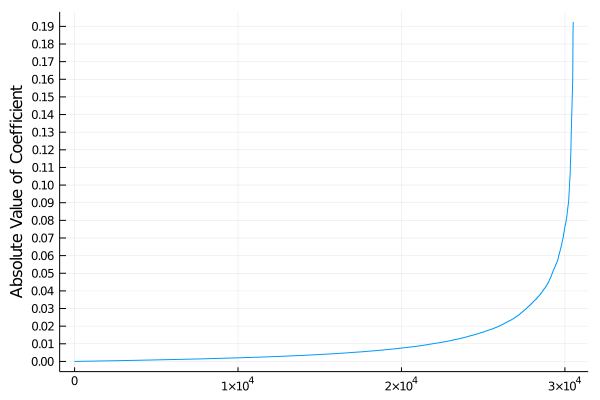

In [198]:
gr()
coef = sort(abs.(ac_clustered[:]))
plot(coef,legend=:none,yticks=0:0.01:maximum(coef))
ylabel!("Absolute Value of Coefficient")

##### iac2d (without adding back loess)

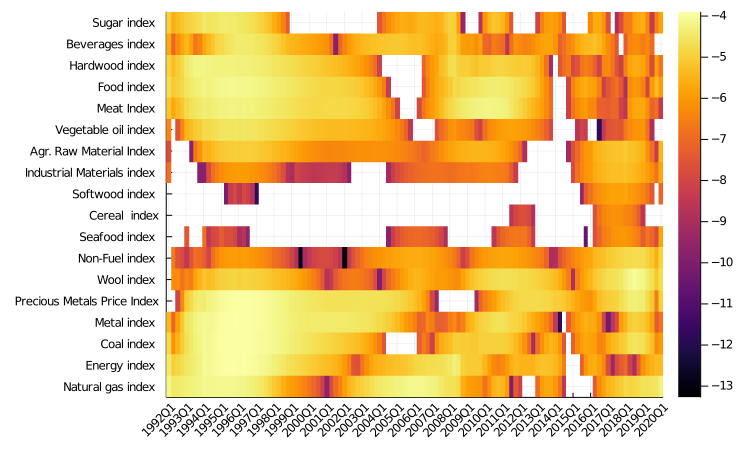

In [204]:
ac_thresh = acthreshold(ac_clustered, "soft", 0.03)
iac = iac2d(ac_thresh)
plot_heatmap_label(iac,comm_clustered)

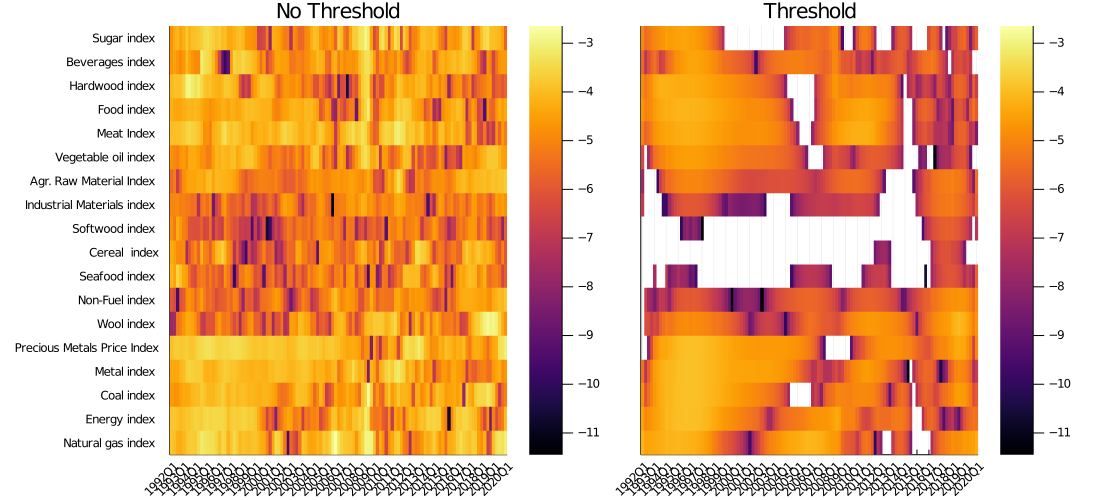

In [210]:
climit = get_clim(x_clustered)

p1 = plot_heatmap_label(x_clustered,comm_clustered,climit)
title!("No Threshold")

p2 = heatmap(log.(abs.(iac)),
    clim=climit,
   colorbar_entry=true,
   size=(800,500),
   xrotation=45,
   xticks=(1:4:size(x)[2],timelabel[1:4:size(x)[2]]),
   #yticks = (1:1:size(x)[1], comm_clustered),
   yticks = nothing,
   yflip=true)
title!("Threshold")

plot(p1, p2)
plot!(size=(1100,500))

##### iac2d (add back loess)

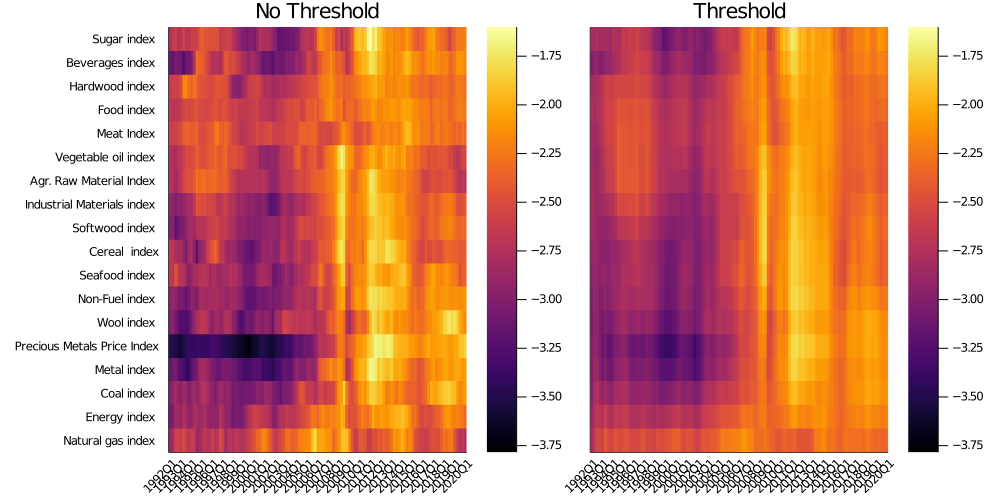

In [217]:
p1 = plot_heatmap_label(x_clustered + loess_fit,comm_clustered)
title!("No Threshold")
plot!(colorbar_entry=false)

p2 = heatmap(log.(abs.(iac + loess_fit)),
   colorbar_entry=false,
   size=(800,500),
   xrotation=45,
   xticks=(1:4:size(x)[2],timelabel[1:4:size(x)[2]]),
   #yticks = (1:1:size(x)[1], comm_clustered),
   yticks = nothing,
   yflip=true)
title!("Threshold")

plot(p1, p2, clim=get_clim(x_clustered + loess_fit),colorbar_entry=true)
plot!(size=(1000,500))

### AC1D Analysis

##### Remove line from each commodity index

In [218]:
x_normalize = normalize(x,"linear","none")
linear_fit = linear_fitted(x,2) # keep the fitted lines

18×113 Adjoint{Float64,Array{Float64,2}}:
 53.5643  54.147   54.7298  55.3125  55.8952  …  117.665   118.247   118.83
 69.8406  70.1677  70.4948  70.8219  71.149      105.822   106.15    106.477
 47.8294  48.5317  49.234   49.9364  50.6387     125.085   125.787   126.489
 54.2639  54.7723  55.2806  55.7889  56.2972     110.178   110.686   111.195
 51.6539  51.7836  51.9134  52.0431  52.1729      65.9272   66.057    66.1867
 77.3346  77.5006  77.6666  77.8325  77.9985  …   95.5918   95.7578   95.9238
 45.5319  45.9144  46.297   46.6795  47.062       87.6075   87.9901   88.3726
 91.2456  91.4521  91.6586  91.8652  92.0717     113.965   114.171   114.378
 52.2427  52.7735  53.3043  53.8351  54.3658     110.629   111.16    111.69
 66.5194  66.8317  67.1439  67.4562  67.7684     100.866   101.179   101.491
 44.4642  44.994   45.5238  46.0537  46.5835  …  102.744   103.274   103.804
 48.2974  48.5578  48.8182  49.0786  49.339       76.9434   77.2038   77.4642
 55.6035  55.9489  56.2943  56.6

##### AC1D

7-element Array{Float64,1}:
 -0.044194173824159244
 -5.887846720064156e-17
  0.397747564417433
  0.7071067811865475
  0.397747564417433
 -5.887846720064156e-17
 -0.044194173824159244

In [282]:
function dyadlength(x)
"""
    dyadlength(x)

    Returns the dyadic length of a sequence `x`
"""
    return trunc(Integer, log2(length(x)))
end

dyadlength (generic function with 1 method)

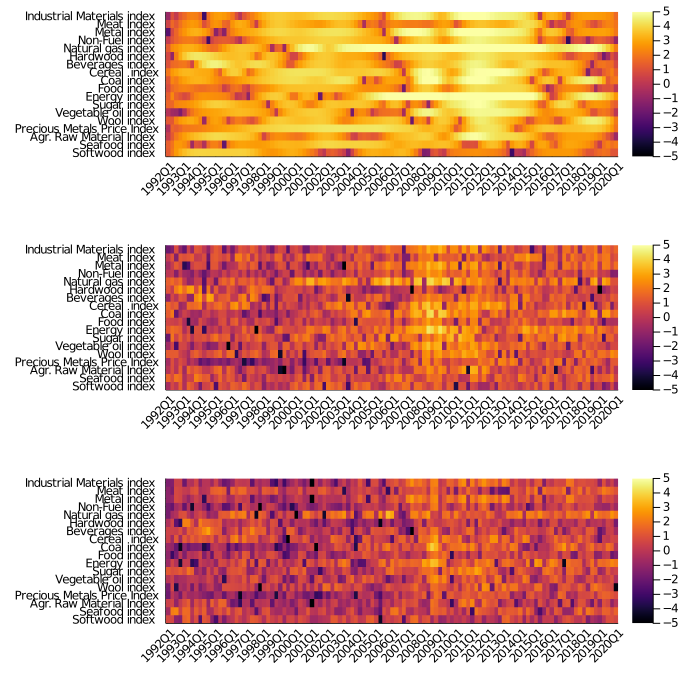

In [295]:
# Set parameters
H = wavelet(WT.db2)
L = 4
Q = qfilter(H)
P = pfilter(H)

n_series = size(x)[1]
n = size(x)[2]
J = dyadlength(zeros(n))
D = J - L + 1

# Autocorrelation
accoef_matrix_3d = Array{Float64, 3}(undef, n, D, n_series)
for i in 1:n_series
    accoef_matrix_3d[:,:,i] = fwt_ac(x_normalize[i,:],L,P,Q)
end

accoef_scales = []
for i in 1:D
    push!(accoef_scales, transpose(accoef_matrix_3d[:,i,:]))
end

# Plot
plot_array = Any[] 
for i in accoef_scales
    #push!(plot_array,heatmap(i,clim=(-75,100))) # make a plot and add it to the plot_array
    push!(plot_array,plot_heatmap_label(i,all_names,(-5,5)))
end
plot(plot_array...,size=(700,700),layout=(D,1))

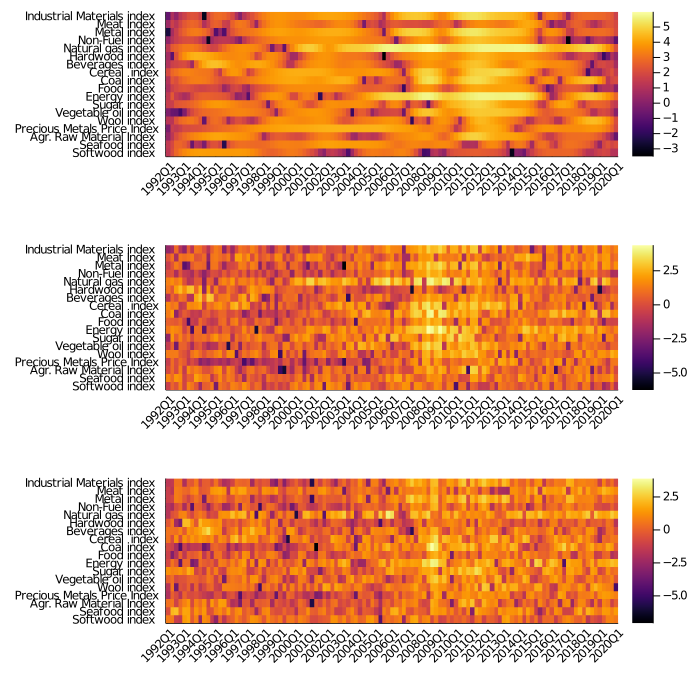

In [280]:
#ac_vec = [fwt_ac(x_normalize[i,:],L,P,Q) for i in 1:n_series]

accoef_matrix_3d = Array{Float64, 3}(undef, n, D, n_series)
for i in 1:n_series
    accoef_matrix_3d[:,:,i] = fwt_ac(x_normalize[i,:],L,P,Q)
end

#accoef_scales = Array{Float64, 2}(undef, n, n_series)
accoef_scales = []
for i in 1:D
    push!(accoef_scales, transpose(accoef_matrix_3d[:,i,:]))
end

climit = get_clim(vcat(accoef_scales...))
plot_array = Any[] 
for i in accoef_scales
    #push!(plot_array,heatmap(i))
    push!(plot_array,plot_heatmap_label(i,all_names)) # make a plot and add it to the plot_array
end
plot(plot_array...,size=(700,700),layout=(D,1))

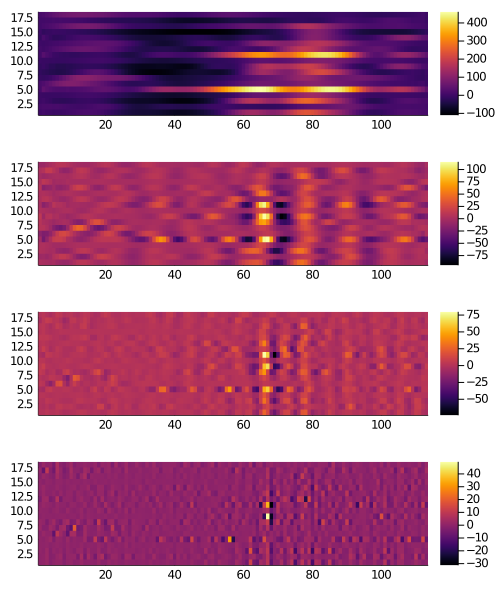

In [301]:
# Set parameters
H = wavelet(WT.db2)
L = 3
Q = qfilter(H)
P = pfilter(H)

n_series = size(x)[1]
n = size(x)[2]
J = dyadlength(zeros(n))
D = J - L + 1

# Autocorrelation
accoef_matrix_3d = Array{Float64, 3}(undef, n, D, n_series)
for i in 1:n_series
    accoef_matrix_3d[:,:,i] = fwt_ac(x_normalize[i,:],L,P,Q)
end

accoef_scales = []
for i in 1:D
    push!(accoef_scales, transpose(accoef_matrix_3d[:,i,:]))
end

# Plot
plot_array = Any[] 
for i in accoef_scales
    #push!(plot_array,heatmap(i,clim=(-75,100))) # make a plot and add it to the plot_array
    push!(plot_array,heatmap(i))
end
plot(plot_array...,size=(500,600),layout=(D,1))

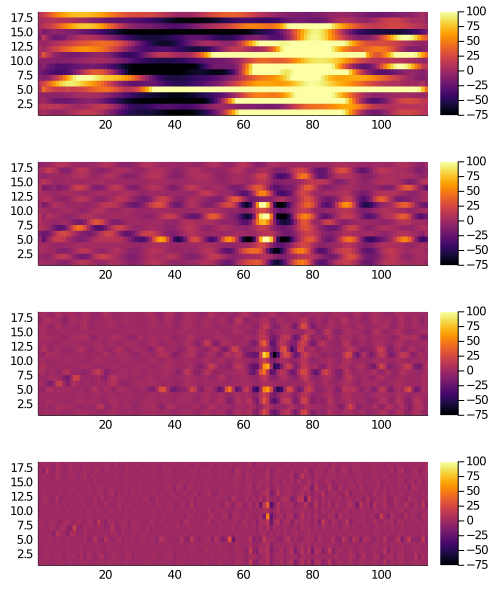

In [305]:
plot_array = Any[] 
for i in accoef_scales
    push!(plot_array,heatmap(i,clim=(-75,100))) # make a plot and add it to the plot_array
end
plot(plot_array...,size=(500,600),layout=(D,1))